粒子群算法PSO求解带约束Rastrigin函数最小值，其数学模型可表示如下：

min Z = 2a + x^2 − acos2πx + y^2 − acos2πy

s.t.  
    x + y <= 6

   3x - 2y <= 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = ['SimHei']  #指定默认字体
mpl.rcParams['axes.unicode_minus'] = False   #正常显示图像中的负号

In [7]:
# PSO的参数
w = 1                 # 惯性因子，一般取1
c1 = 2                # 学习因子，一般取2
c2 = 2
r1 = None 
r2 = None
dim = 2               # 变量的个数
size = 100            # 种群的大小
iter_num = 1000       # 迭代次数
max_val = 0.5         # 限制粒子的最大速度
fitness_value_list = []   # 维护每次迭代过程中的种群适应度

# 计算适应度函数
def calc_f(X):
    a = 10
    pi = np.pi
    x = X[0]
    y = X[1]
    return 2*a + x**2 - a*np.cos(2*pi*x) + y**2 - a*np.cos(2*pi*y)

# 计算第一个约束的惩罚项函数
# 思想类似线性规划内点法，都是通过增加惩罚函数，迫使模型在迭代计算的过程中始终在可行域内寻优
def calc_e1(X):
    e = X[0] + X[1] - 6
    return max(0,e)

# 计算第二个约束的惩罚项函数
def calc_e2(X):
    e = 3*X[0] - 2*X[1] - 5
    return max(0,e)

# e1和e2列向量表示每个粒子的第1个、第2个约束的惩罚项，根据每个粒子的约束惩罚项计算Lj权重值
def calc_Lj(e1,e2):
    # 防止分母为0
    if (e1.sum()+e2.sum()) <= 0:
        return 0,0
    else:
        L1 = e1.sum() / (e1.sum()+e2.sum())
        L2 = e2.sum() / (e1.sum()+e2.sum())
    return L1,L2

# 速度更新函数和位置更新函数类似无约束优化的代码
# 速度更新函数
def velocity_update(V,X,pbest,gbest):
    '''
    :param V:粒子当前的速度矩阵,size*2
    :param X:粒子当前的位置矩阵,size*2
    :param pbest:每个粒子的历史最优位置,size*2
    :param gbest:种群历史最优位置,1*2
    '''
    r1 = np.random.random((size,1))
    r2 = np.random.random((size,1))
    V = w*V + c1*r1*(pbest-X) + c2*r2*(gbest-X)
    # 防止越界
    V[V < -max_val] = -max_val
    V[V > max_val] = max_val
    return V

#位置更新函数
def position_update(X,V):
    return X+V

In [9]:
# 每个粒子历史最优位置更新函数
def update_pbest(pbest,pbest_fitness,pbest_e,xi,xi_fitness,xi_e):
    # 下面的0.0000001是考虑到计算机的数值精度位置，值等同于0
    # 规则1，如果pbest和xi都没有违反约束，则取适应度小的
    if pbest_e <= 0.0000001 and xi_e <= 0.0000001:
        if pbest_fitness <= xi_fitness:
            return pbest,pbest_fitness,pbest_e
        else:
            return xi,xi_fitness,xi_e
    
    # 规则2，如果当前位置违反约束而历史最优没有违反约束，则取历史最优
    if pbest_e < 0.0000001 and xi_e >= 0.0000001:
        return pbest,pbest_fitness,pbest_e
    
    # 规则3，如果当前位置没违反约束而历史最优违反约束，则取当前位置
    if pbest_e >= 0.0000001 and xi_e < 0.0000001:
        return xi,xi_fitness,xi_e
    
    # 规则4，如果pbest和xi都违反约束，则取适应度小的
    if pbest_fitness <= xi_fitness:
        return pbest,pbest_fitness,pbest_e
    else:
        return xi,xi_fitness,xi_e
    
# 群体历史最优位置更新函数
def update_gbest(gbest,gbest_fitness,gbest_e,pbest,pbest_fitness,pbest_e):
    # 先寻找约束惩罚项为0的最优个体，如果每个个体的约束惩罚项都大于0则找适应度最小的个体
    pbest2 = np.concatenate([pbest,
                            pbest_fitness.reshape(-1,1),
                            pbest_e.reshape(-1,1)],axis=1)     # 将几个矩阵拼接在一起
    pbest2_1 = pbest2[pbest2[:,-1] <= 0.0000001]               # 找出没有违反约束的个体
    if len(pbest2_1) > 0:
        pbest2_1 = pbest2_1[pbest2_1[:,2].argsort()]           # 根据适应度值排序
    else:
        pbest2_1 = pbest2[pbest2[:,2].argsort()]               # 所有个体都违反约束，则直接按照原来的适应度值排序
    
    # 当前迭代的最优个体
    pbesti,pbesti_fitness,pbesti_e = pbest2_1[0,:2],pbest2_1[0,2],pbest2_1[0,3]
    
    # 当前最优和局部最优的比较
    # 规则1，两者都没有约束
    if gbest_e <= 0.0000001 and pbesti_e <= 0.0000001:
        if gbest_fitness < pbesti_fitness:
            return gbest,gbest_fitness,gbest_e
        else:
            return pbesti,pbesti_fitness,pbesti_e
    # 规则2，全局最优违反约束，个体最优没违反约束
    if gbest_e > 0.0000001 and pbesti_e <= 0.0000001:
        return pbesti,pbesti_fitness,pbesti_e
    # 规则3，全局最优没有违反约束，个体最优违反约束
    if gbest_e <= 0.0000001 and pbesti_e > 0.0000001:
        return gbest,gbest_fitness,gbest_e
    # 规则4，全局最优和个体最优都违反约束
    if gbest_fitness < pbesti_fitness:
        return gbest,gbest_fitness,gbest_e
    else:
        return pbesti,pbesti_fitness,pbesti_e

In [22]:
# 主函数
def PSO_constrained():
    # 初始化一个矩阵info记录
    '''
    1.种群每个粒子的历史最优位置对应的适应度
    2.历史最优位置对应的惩罚项
    3.当前适应度
    4.当前目标函数值
    5.约束1惩罚项
    6.约束2惩罚项
    7.惩罚项的和
    '''
    info = np.zeros((size,7))
    
    # 初始化种群各个粒子的位置
    X = np.random.uniform(-5,5,size=(size,dim))
    
    # 初始化种群各个粒子的速度
    V = np.random.uniform(-0.5,0.5,size=(size,dim))
    
    # 初始化历史最优位置为当前位置
    pbest = X
    
    # 初始化，计算每个粒子的适应度
    for i in range(size):
        info[i,3] = calc_f(X[i])      # 目标函数值
        info[i,4] = calc_e1(X[i])     # 第一个约束的惩罚项
        info[i,5] = calc_e2(X[i])     # 第二个约束的惩罚项
    
    # 初始化，计算惩罚项的权重及适应度值
    L1,L2 = calc_Lj(info[i,4],info[i,5])
    info[:,2] = info[:,3] + L1*info[i,4] + L2*info[i,5]
    info[:,6] = L1*info[i,4] + L2*info[i,5]
    
    # 初始化，历史最优
    info[:,0] = info[:,2]
    info[:,1] = info[:,6]
    
    # 全局最优
    gbest_i = info[:,0].argmin()         # 全局最优的粒子编号
    gbest = X[gbest_i]                   # 全局最优粒子的位置
    gbest_fitness = info[gbest_i,0]  
    gbest_e = info[gbest_i,1]
    
    # 维护迭代过程中的最优适应度值
    fitness_value_list.append(gbest_fitness)
    
    #接下来开始迭代
    for j in range(iter_num):
        # 更新速度
        V = velocity_update(V,X,pbest=pbest,gbest=gbest)
        # 更新位置
        X = position_update(X,V)
        
        # 就算每个粒子的目标函数和约束惩罚项
        for i in range(size):
            info[i:,3] = calc_f(X[i])
            info[i:,4] = calc_e1(X[i])
            info[i:,5] = calc_e2(X[i])
        
        # 计算惩罚项的权重及适应度值
        L1,L2 = calc_Lj(info[i,4],info[i,5])
        info[:,2] = info[:,3] + L1*info[i,4] + L2*info[i,5]
        info[:,6] = L1*info[i,4] + L2*info[i,5]
        
        # 更新历史最优位置
        for i in range(size):
            pbesti = pbest[i]
            pbest_fitness = info[i,0]
            pbest_e = info[i,1]
            xi = X[i]
            xi_fitness = info[i,2]
            xi_e = info[i,6]
            
            # 计算个体历史最优
            pbesti,pbest_fitness,pbest_e = \
                update_pbest(pbesti,pbest_fitness,pbest_e,xi,xi_fitness,xi_e)
            
            pbest[i] = pbesti
            info[i,0] = pbest_fitness
            info[i,1] = pbest_e
            
        # 更新全局最优
        pbest_fitness = info[:,2]
        pbest_e = info[:,6]
        gbest,gbest_fitness,gbest_e = \
            update_gbest(gbest,gbest_fitness,gbest_e,pbest,pbest_fitness,pbest_e)
        
        # 记录当前迭代全局之硬度
        fitness_value_list.append(gbest_fitness)   
        
    # 可视化
    print('迭代最优结果是：%.5f' % calc_f(gbest))            #理论最优值是0
    print('迭代最优变量是：x=%.5f,y=%.5f' % (gbest[0],gbest[1]))
    print('迭代约束惩罚项是：',gbest_e)     
    plt.plot(fitness_value_list[:40],color = 'b')
    plt.title('迭代过程')

迭代最优结果是：0.00000
迭代最优变量是：x=0.00001,y=0.00000
迭代约束惩罚项是： 0.0


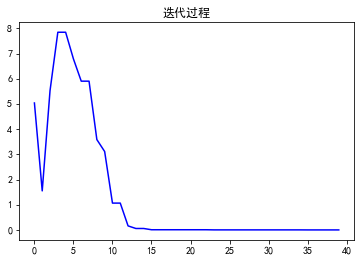

In [23]:
if __name__ == "__main__":
    PSO_constrained()